## Baby Names
### Data obtained from the Social Security Administration
Note: This government data assumes binary biological sex


In [1]:
from itertools import product
import os
import re

from dtaidistance import dtw
import glob
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

PATH = r'~/Desktop/names'  
%matplotlib inline

### Stiching together datasets of each year

In [2]:
all_files = glob.glob(os.path.expanduser(os.path.join(PATH, "*.txt"))) 
list_of_dfs = []
col_names = ['name','sex','freq']

In [3]:
def get_year_from_file_path(full_path):
    """
    Extracts and returns just the year from the full path string

    Args:
        full_path: string, the full path to the dataset
    Returns:
        string of the year in the full path
    """
    file = os.path.split(full_path)[1]
    match = re.search(r'([a-zA-Z]+)(\d+)\.(.+)', file)
    return match.group(2)

In [4]:
# Cycle through all files, processing them and then concat-ing together
for filename in all_files:
    temp_df = pd.read_csv(filename, index_col=None, header=None, names=col_names)
    temp_df['year'] = get_year_from_file_path(filename)
    list_of_dfs.append(temp_df)
    
all_dfs = pd.concat(list_of_dfs, axis=0, ignore_index=True)

In [5]:
# Make sure int columns are appropriate types
all_dfs = all_dfs.astype({"freq": int, "year": int})

# Sort by year, sex, and freq
all_dfs.sort_values(by = ['year', 'sex', 'freq'], ascending = [True, True, False], inplace = True)

# Check that it looks good (what were the most common female names in the oldest years of datasets)
all_dfs.head()

,name,sex,freq,year
1839974,Mary,F,7065,1880
1839975,Anna,F,2604,1880
1839976,Emma,F,2003,1880
1839977,Elizabeth,F,1939,1880
1839978,Minnie,F,1746,1880


### Initial processing of the data

Because of some trickiness downstream in the processing (some names occur among females and males), we now need to split up the sexes into separate dataframes.

In [6]:
girl_df = (all_dfs[['name', 'year', 'freq']][all_dfs['sex'] == 'F']).reset_index(drop = True)
boy_df = (all_dfs[['name', 'year', 'freq']][all_dfs['sex'] == 'M']).reset_index(drop = True)

In [7]:
def add_missing_years(input_dataset):
    """
    If a name present in the dataset and is missing from any years, these years are added with name freqs of zero.

    Args:
        input_dataset: a pandas dataframe from above cell, for either girls or boys
    Returns:
        A pandas dataset with missing years added in
    """
    temp_combinations = pd.DataFrame(
        list(product(list(input_dataset['name'].unique()), list(input_dataset['year'].unique()))), columns=['name','year']
    )
    temp_df = input_dataset.merge(temp_combinations, how = 'right', left_on = ['name', 'year'], right_on = ['name', 'year'])
    temp_df['freq'].fillna(0, inplace = True)
    return temp_df.sort_values(by = ['name', 'year'], ascending = [True, True], inplace = False)

In [8]:
girl_df2 = add_missing_years(girl_df)
boy_df2 = add_missing_years(boy_df)

In [9]:
# Making sure this worked. Picking an uncommon name...
boy_df2[boy_df2['name'] == 'Zzyzx'].tail()

,name,year,freq
5127284,Zzyzx,2014,0.0
5127285,Zzyzx,2015,0.0
5127286,Zzyzx,2016,0.0
5127287,Zzyzx,2017,0.0
800518,Zzyzx,2018,5.0


In [10]:
# Explore some individual names

def plot_individual_name(name, sex):
    """
    Takes a name (string, and case-sensitive) and sex ('M' or 'F') and produces a time series plot of its popularity over time
    
    Arguments:
        name: string, self-explanatory
        sex: string, 'M' or 'F'
    """
    plt.clf()
    if sex == 'F':
        temp_df = girl_df2[girl_df2['name'] == name]
    else:
        temp_df = boy_df2[boy_df2['name'] == name]
    if temp_df.empty:
        return "No one was born with that name!"
    else:
        plt.figure(figsize=(14, 9)) 
        ax = plt.subplot(111)  
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False) 
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel('Year', fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14)
        ax.set_title(f'Popularity of name: "{name}"')
        plt.xticks(np.arange(1800, 2022, 10), fontsize=14)  
        plt.yticks(fontsize=14)  
        plt.plot(temp_df['year'],temp_df['freq'])
        plt.show()

<Figure size 432x288 with 0 Axes>

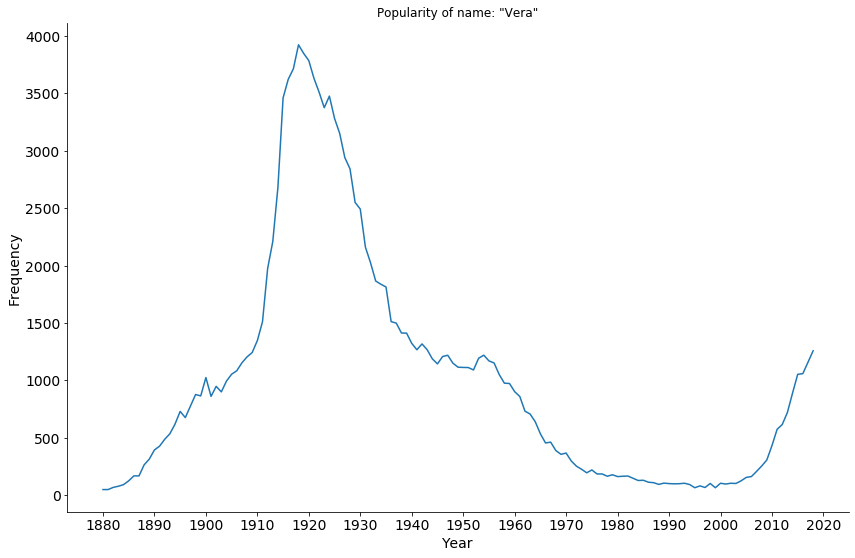

In [11]:
# Some names are making a comeback...
plot_individual_name("Vera", "F")

<Figure size 432x288 with 0 Axes>

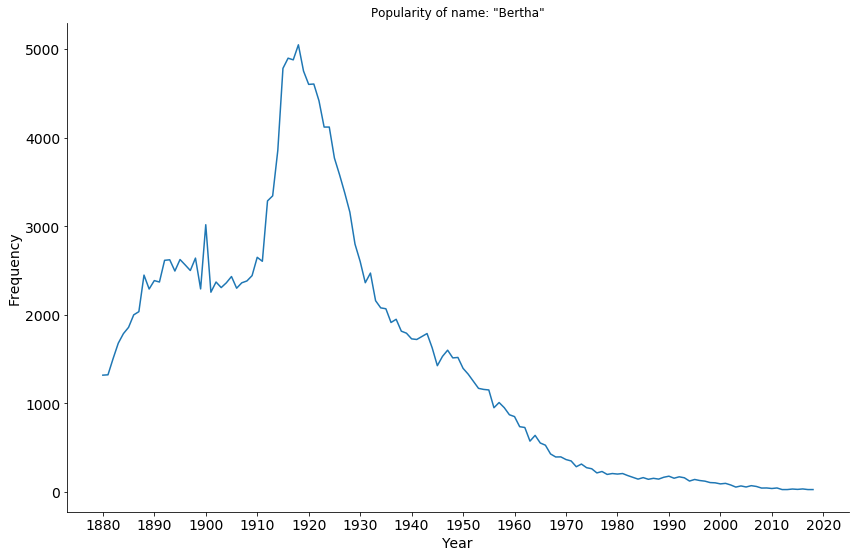

In [12]:
# When is the last time you met a Bertha?
plot_individual_name("Bertha", "F")

<Figure size 432x288 with 0 Axes>

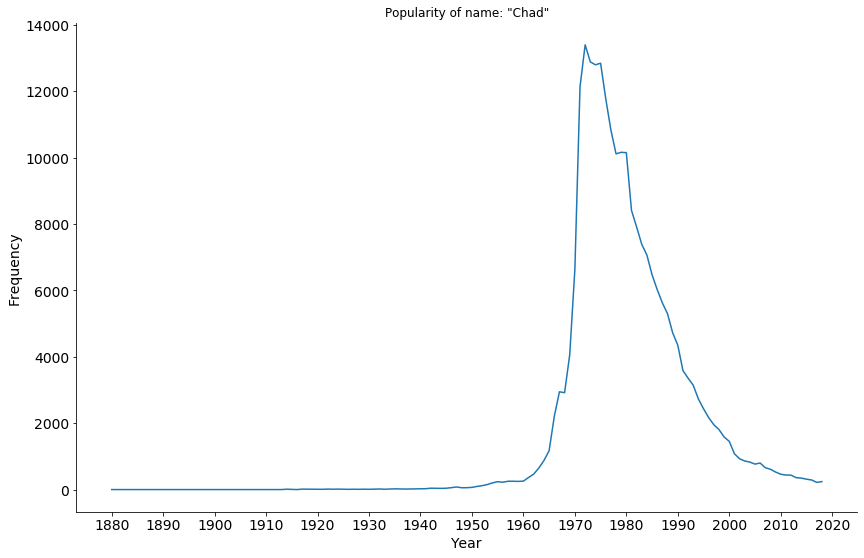

In [13]:
# Some names have short phases...
plot_individual_name("Chad", "M")

<Figure size 432x288 with 0 Axes>

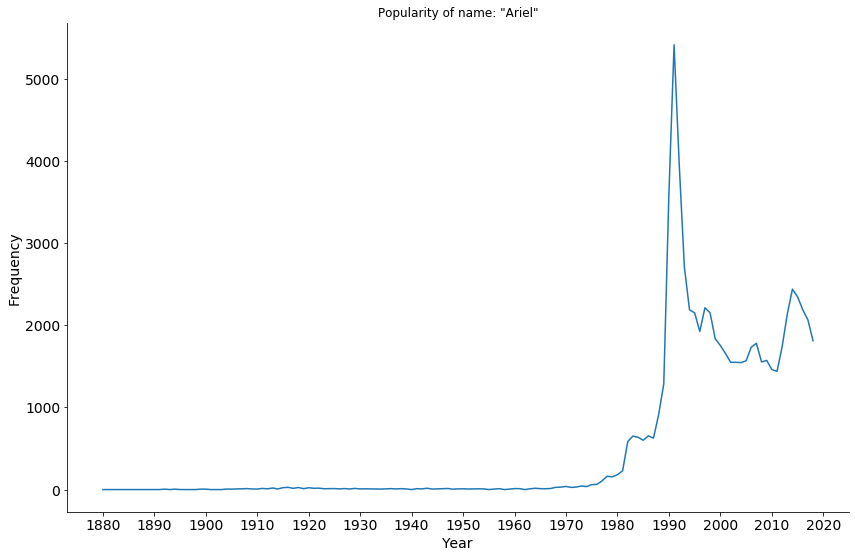

In [14]:
# Some names have short phases...
plot_individual_name("Ariel", "F")

### Further processing of the data

In [15]:
# Filtering out low frequency names (if less than 20,000 people are born with that name, exclude it)
# Also, let's focus on the last 100 years

def filter_dfs(df, freq_cutoff, year_cutoff):
    """
    Filters the girl and boy datasets by frequency of name and year
    
    Arguments:
        df: pandas dataframe, for girls or boys
        freq_cutoff: int, if names don't have this freq over all of the years, exclude it
        year_cutoff: int, focus on the years after this cutoff
    Returns: a pandas dataframe that has been filtered
    """
    temp_df = df.groupby(['name'])['freq'].sum().reset_index()
    temp_df = temp_df[temp_df['freq'] >= freq_cutoff]
    temp_df2 = df[df['name'].isin(temp_df['name'])]
    return temp_df2[temp_df2['year'] >= year_cutoff].reset_index(drop = True, inplace = False)
    

In [16]:
girl_df3 = filter_dfs(girl_df2, 20000, 1920)
boy_df3 = filter_dfs(boy_df2, 20000, 1920)

In [17]:
# Reformat data for tslearn. Needs to look like this: [[3,4,6,6], [0,0,1,10]]

def reformat_for_ts(df):
    """
    Formats data for tslearn library
    
    Arguments:
        df: filtered pandas dataframe, for girls or boys
    Returns: a list of lists
    """
    list_of_ts = []
    for name in tqdm(df.name.unique()):
        temp_df = df[df['name'] == name]
        list_of_ts.append(list(temp_df['freq']))
    return list_of_ts

In [18]:
# Carry out this reformatting and also re-scale time-series so they are comparable (SUPER IMPORTANT)
girl_ts_data = TimeSeriesScalerMeanVariance().fit_transform(to_time_series_dataset(reformat_for_ts(girl_df3)))
boy_ts_data = TimeSeriesScalerMeanVariance().fit_transform(to_time_series_dataset(reformat_for_ts(boy_df3)))


100%|██████████| 763/763 [00:08<00:00, 93.06it/s]


### Determine the optimal number of clusters for boys and girls. Using Dynamic Time Warping to create distance measures between time series.

![Dynamic Time Warping](https://upload.wikimedia.org/wikipedia/commons/a/ab/Dynamic_time_warping.png)

In [19]:
# Starting with girls
sum_of_squared_distances = []
K = range(2,11)
for k in K:
    print(f"Trying k = {k}")
    girl_km = TimeSeriesKMeans(n_clusters=k, verbose=True, metric="softdtw", metric_params={"gamma_sdtw": 0.1}, max_iter = 5, random_state=333)
    girl_km.fit(girl_ts_data)
    sum_of_squared_distances.append(girl_km.inertia_)

Trying k = 2
7659.869 --> 113.356 --> 115.988 --> 119.687 --> 123.939 --> 
Trying k = 3
142.196 --> 102.036 --> 104.180 --> 104.873 --> 104.618 --> 
Trying k = 4
97.996 --> 108.019 --> 107.849 --> 107.709 --> 108.184 --> 
Trying k = 5
81.650 --> 111.046 --> 111.010 --> 111.058 --> 110.927 --> 
Trying k = 6
82.225 --> 112.905 --> 112.809 --> 113.419 --> 113.254 --> 
Trying k = 7
84.676 --> 115.062 --> 114.039 --> 114.338 --> 114.314 --> 
Trying k = 8
108.706 --> 108.342 --> 110.194 --> 111.554 --> 112.406 --> 
Trying k = 9
109.589 --> 108.304 --> 110.717 --> 113.684 --> 114.695 --> 
Trying k = 10
112.198 --> 111.679 --> 114.843 --> 117.569 --> 118.762 --> 


<Figure size 432x288 with 0 Axes>

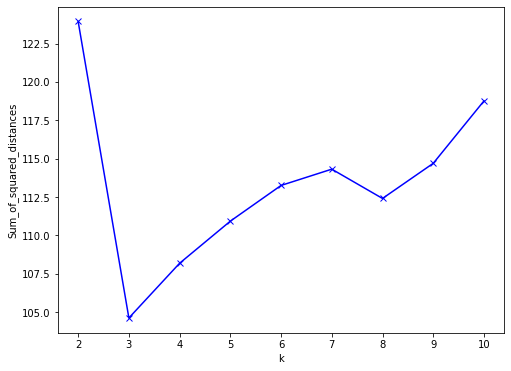

In [20]:
# Looks like three clusters could be a winner here

plt.clf()
plt.figure(figsize=(8, 6)) 
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.show()

In [21]:
# Continuing with boys
sum_of_squared_distances = []
K = range(2,11)
for k in K:
    print(f"Trying k = {k}")
    boy_km = TimeSeriesKMeans(n_clusters=k, verbose=True, metric="softdtw", metric_params={"gamma_sdtw": 0.1}, max_iter = 3, random_state=333)
    boy_km.fit(boy_ts_data)
    sum_of_squared_distances.append(boy_km.inertia_)

Trying k = 2
3818.352 --> 124.202 --> 117.064 --> 
Trying k = 3
1847.902 --> 94.591 --> 90.907 --> 
Trying k = 4
169.077 --> 113.741 --> 112.659 --> 
Trying k = 5
169.154 --> 110.042 --> 109.777 --> 
Trying k = 6
171.477 --> 114.387 --> 114.374 --> 
Trying k = 7
171.497 --> 117.964 --> 119.384 --> 
Trying k = 8
168.855 --> 123.542 --> 123.140 --> 
Trying k = 9
168.644 --> 124.016 --> 122.953 --> 
Trying k = 10
171.705 --> 127.169 --> 124.917 --> 


<Figure size 432x288 with 0 Axes>

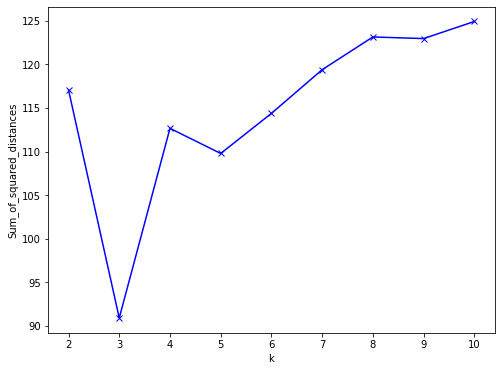

In [22]:
# It looks like five clusters should be sufficient

plt.clf()
plt.figure(figsize=(8, 6)) 
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.show()

### Create clusters and explore results

142.196 --> 102.036 --> 104.180 --> 104.873 --> 104.618 --> 105.083 --> 105.131 --> 106.395 --> 106.335 --> 106.440 --> 


<Figure size 432x288 with 0 Axes>

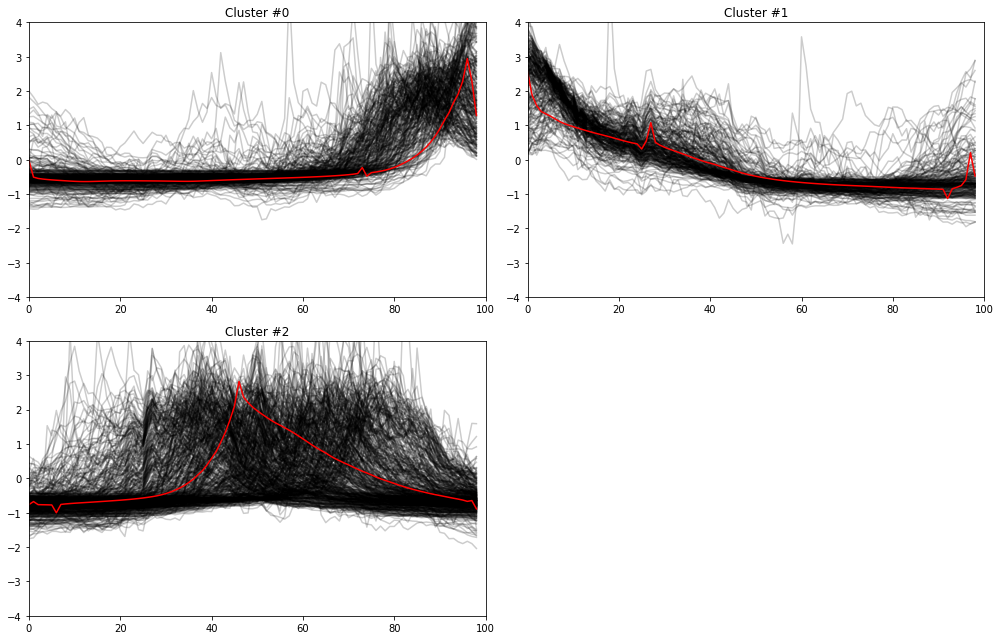

In [23]:
girl_km = TimeSeriesKMeans(n_clusters=3, verbose=True, metric="softdtw", metric_params={"gamma_sdtw": 0.1}, max_iter = 10, random_state=333)
girl_km.fit(girl_ts_data)
girl_predictions = girl_km.predict(girl_ts_data)

plt.clf()
plt.figure(figsize=(14, 9)) 
for yi in range(3):
    plt.subplot(2, 2, yi + 1)
    for xx in girl_ts_data[girl_predictions == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(girl_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 100)
    plt.ylim(-4, 4)
    plt.title(f"Cluster #{yi}")

plt.tight_layout()
plt.show()

169.154 --> 110.042 --> 109.777 --> 110.044 --> 110.923 --> 110.437 --> 110.536 --> 110.799 --> 110.576 --> 110.674 --> 


<Figure size 432x288 with 0 Axes>

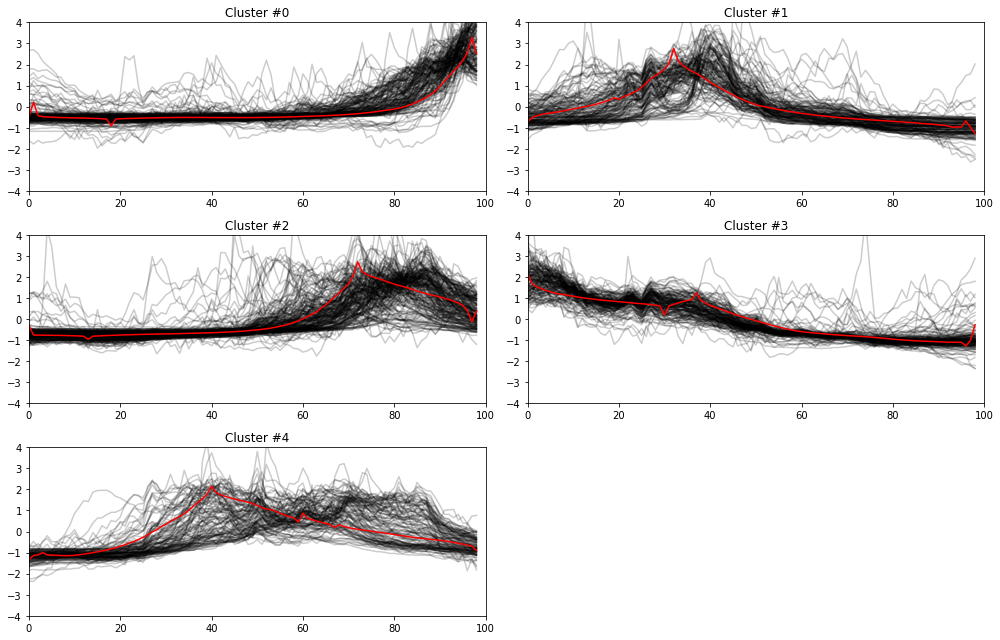

In [24]:
boy_km = TimeSeriesKMeans(n_clusters=5, verbose=True, metric="softdtw", metric_params={"gamma_sdtw": 0.1}, max_iter = 10, random_state=333)
boy_km.fit(boy_ts_data)
boy_predictions = boy_km.predict(boy_ts_data)

plt.clf()
plt.figure(figsize=(14, 9)) 
for yi in range(5):
    plt.subplot(3, 2, yi + 1)
    for xx in boy_ts_data[boy_predictions == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(boy_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 100)
    plt.ylim(-4, 4)
    plt.title(f"Cluster #{yi}")

plt.tight_layout()
plt.show()

In [25]:
# Function to calculate DTW distances between each observation and cluster center, which will allow us to find each cluster's exemplar.

def calc_cluster_center_dist(predictions, final_filtered_dataset, kmeans_model, num_clusters):
    """
    Generates a dataset with distances of each name to a cluster center
    
    Arguments:
        predictions: numpy array of the sex-specific clustering predictions
        final_filtered_dataset: sex-specific pandas dataframe, final filtered dataset with names, years, and frequencies
        kmeans_model: the sex-specific tslearn clustering object
        num_clusters: int, number of clusters to consider
        
    Returns: Pandas dataframe with the names, predicted cluster number, and DTW distances to each cluster center
    """
    
    named_results = pd.DataFrame({'predictions':predictions, 'names':final_filtered_dataset.name.unique()})

    for cluster_num in range(num_clusters):
        print(f'Running distance calcs for cluster # {cluster_num}')
        distances = []
        center = kmeans_model.cluster_centers_[cluster_num].flatten()
        for individual_ts in kmeans_model.X_fit_:
            observation = individual_ts.flatten()
            distances.append(dtw.distance(center, observation))
        named_results['cluster' + f'_{cluster_num}' + '_dist'] = distances
    
    return named_results

In [26]:
boy_distances_df = calc_cluster_center_dist(boy_predictions, boy_df3, boy_km, 5)

Running distance calcs for cluster # 0
Running distance calcs for cluster # 1
Running distance calcs for cluster # 2
Running distance calcs for cluster # 3
Running distance calcs for cluster # 4


In [27]:
girl_distances_df = calc_cluster_center_dist(girl_predictions, girl_df3, girl_km, 3)

Running distance calcs for cluster # 0
Running distance calcs for cluster # 1
Running distance calcs for cluster # 2


In [28]:
# Function to get a few exemplar names from each cluster

def get_example_names(distance_df, example_num = 3):
    """
    Gives you some exemplar names for a given cluster
    
    Arguments:
        distance_df: pandas dataframe with the names, predicted cluster, and DTW distances
        example_num: int, number of names from a cluster to get back
        
    Returns: a few exemplar names from the cluster
    """
    columns = [col_name for col_name in distance_df.columns if '_dist' in col_name]
    for col in columns:
        distance_df.sort_values(col, ascending = True, inplace = True)
        print(f'Top names for {col}:  {", ".join(list(distance_df["names"].iloc[0:example_num]))}')

In [29]:
get_example_names(boy_distances_df)

Top names for cluster_0_dist:  Owen, Cruz, Carter
Top names for cluster_1_dist:  Dale, Roger, Tony
Top names for cluster_2_dist:  Jacob, Trenton, Brennan
Top names for cluster_3_dist:  Archie, Walter, Louis
Top names for cluster_4_dist:  Timothy, Brian, Eric


In [30]:
get_example_names(girl_distances_df)

Top names for cluster_0_dist:  Arianna, Sophia, Makenzie
Top names for cluster_1_dist:  Flora, Maxine, Lillie
Top names for cluster_2_dist:  Melissa, Amy, Erin


In [31]:
# Print out final plots of the clusters

def save_final_plots_to_disk(predictions, final_filtered_dataset, scaled_ts_data, num_clusters):
    """
    Saves 
    
    Arguments:
        predictions: numpy array of the sex-specific clustering predictions
        final_filtered_dataset: sex-specific pandas dataframe, final filtered dataset with names, years, and frequencies
        scaled_ts_data: the sex-specific numpy array of re-scaled time-series data
        num_clusters: int, number of clusters to consider
        
    Returns: None
    """    
    color_dict = {
        0:'darkorange',
        1:'forestgreen',
        2:'firebrick',
        3:'royalblue',
        4:'darkmagenta'
    }

    named_results = pd.DataFrame({'predictions':predictions, 'name':final_filtered_dataset.name.unique()})
    
    temp_girl_df = pd.Panel(scaled_ts_data).to_frame().reset_index(drop = True)
    temp_girl_df.columns = final_filtered_dataset.name.unique()
    
    for cluster in range(num_clusters):
        names = list(named_results[named_results['predictions'] == cluster]['name'])
        plt.clf()
        plt.figure(figsize=(14, 9)) 
        ax = plt.subplot(111) 
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False) 
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel('Year', fontsize=14)
        ax.set_ylabel('Scaled Frequency', fontsize=14)
        plt.xticks(np.arange(1920, 2022, 10), fontsize=14)  
        plt.yticks(fontsize=14)  
        for name in names:
            plt.plot(range(1920,2019), temp_girl_df[name], alpha=0.1, color=color_dict[cluster])
        plt.savefig(f'{cluster}.png', bbox_inches='tight', dpi=300)
        plt.clf()


In [32]:
save_final_plots_to_disk(girl_predictions, girl_df3, girl_ts_data, 3)

/Users/ronikobrosly/.virtualenvs/baby_names/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

<Figure size 1008x648 with 0 Axes>

<Figure size 1008x648 with 0 Axes>

<Figure size 1008x648 with 0 Axes>

In [33]:
save_final_plots_to_disk(boy_predictions, boy_df3, boy_ts_data, 5)

/Users/ronikobrosly/.virtualenvs/baby_names/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

<Figure size 1008x648 with 0 Axes>

<Figure size 1008x648 with 0 Axes>

<Figure size 1008x648 with 0 Axes>

<Figure size 1008x648 with 0 Axes>

<Figure size 1008x648 with 0 Axes>